In [298]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from scipy.stats import chi2_contingency

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

In [299]:
applicant = pd.read_csv('data/applicant.csv')
applicant.drop(['Telephone', 'Balance_in_existing_bank_account_(lower_limit_of_bucket)', 'Balance_in_existing_bank_account_(upper_limit_of_bucket)'], axis=1, inplace=True)
for i in range(len(applicant)):
    if not pd.isna(applicant['Has_been_employed_for_at_least'].iloc[i]):
        applicant['Has_been_employed_for_at_least'].iloc[i] = int(applicant['Has_been_employed_for_at_least'].iloc[i][0])
    if not pd.isna(applicant['Has_been_employed_for_at_most'].iloc[i]):
        applicant['Has_been_employed_for_at_most'].iloc[i] = int(applicant['Has_been_employed_for_at_most'].iloc[i][0])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [300]:
loan = pd.read_csv('data/loan.csv')
loan['Other_EMI_plans'].fillna('none', inplace=True)
loan.drop('loan_application_id', inplace=True, axis=1)

In [301]:
cs = pd.merge(applicant, loan, on='applicant_id')
cs.drop('applicant_id', axis=1, inplace=True)
cs['Property'].fillna('none', inplace=True)
cs['Purpose'].fillna('none', inplace=True)
cs.replace({'Gender': {'female': 0, 'male': 1}}, inplace=True)
cs.head()

,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Has_been_employed_for_at_most,Foreign_worker,...,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Other_EMI_plans,Number_of_existing_loans_at_this_bank,Loan_history,high_risk_applicant
0,67,1,single,1,own,4,skilled employee / official,7,NaN,1,...,electronic equipment,1169000,4,real estate,0,0,none,2,critical/pending loans at other banks,0
1,22,0,divorced/separated/married,1,own,2,skilled employee / official,1,4,1,...,electronic equipment,5951000,2,real estate,0,0,none,1,existing loans paid back duly till now,1
2,49,1,single,2,own,3,unskilled - resident,4,7,1,...,education,2096000,2,real estate,0,0,none,1,critical/pending loans at other banks,0
3,45,1,single,2,for free,4,skilled employee / official,4,7,1,...,FF&E,7882000,2,building society savings agreement/life insurance,0,1,none,1,existing loans paid back duly till now,0
4,53,1,single,2,for free,4,skilled employee / official,1,4,1,...,new vehicle,4870000,3,none,0,0,none,2,delay in paying off loans in the past,1


In [302]:
#Defining bar chart function
def bar(feature, df=cs):
    #Groupby the categorical feature
    temp_df = df.groupby([feature, 'high_risk_applicant']).size().reset_index()
    temp_df = temp_df.rename(columns={0:'Count'})
    #Calculate the value counts of each distribution and it's corresponding Percentages
    value_counts_df = df[feature].value_counts().to_frame().reset_index()
    categories = [cat[1][0] for cat in value_counts_df.iterrows()]
    #Calculate the value counts of each distribution and it's corresponding Percentages
    num_list = [num[1][1] for num in value_counts_df.iterrows()]
    div_list = [element / sum(num_list) for element in num_list]
    percentage = [round(element * 100,1) for element in div_list]
    #Defining string formatting for graph annotation
    #Numeric section
    def num_format(list_instance):
        formatted_str = ''
        for index,num in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{num}%, ' #append to empty string(formatted_str)
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{num}% & '
            else:
                formatted_str=formatted_str+f'{num}%'
        return formatted_str
    #Categorical section
    def str_format(list_instance):
        formatted_str = ''
        for index, cat in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{cat}, '
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{cat} & '
            else:
                formatted_str=formatted_str+f'{cat}'
        return formatted_str


    #Running the formatting functions
    num_str = num_format(percentage)
    cat_str = str_format(categories)
    
    #Setting graph framework
    fig = px.bar(temp_df, x=feature, y='Count', color='high_risk_applicant', title=f'Risk by {feature}', barmode="group", color_discrete_sequence=["green", "red"])
    fig.add_annotation(
                text=f'Value count of distribution of {cat_str} are<br>{num_str} percentage respectively.',
                align='left',
                showarrow=False,
                xref='paper',
                yref='paper',
                x=1.4,
                y=1.3,
                bordercolor='black',
                borderwidth=1)
    fig.update_layout(
        # margin space for the annotations on the right
        margin=dict(r=400),
    )
     
    return fig.show()

In [326]:
for i in cs.columns[:-1]:
    bar(i)

In [304]:
cs = cs.dropna()
cs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 578 entries, 1 to 998
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   Primary_applicant_age_in_years               578 non-null    int64 
 1   Gender                                       578 non-null    int64 
 2   Marital_status                               578 non-null    object
 3   Number_of_dependents                         578 non-null    int64 
 4   Housing                                      578 non-null    object
 5   Years_at_current_residence                   578 non-null    int64 
 6   Employment_status                            578 non-null    object
 7   Has_been_employed_for_at_least               578 non-null    object
 8   Has_been_employed_for_at_most                578 non-null    object
 9   Foreign_worker                               578 non-null    int64 
 10  Savings_accoun

In [305]:
convert_dict = {'Gender': object,
                'Foreign_worker': object,
                'Has_coapplicant': object,
                'Has_guarantor': object,
                'high_risk_applicant': object,
                'Has_been_employed_for_at_least': int,
                'Has_been_employed_for_at_most': int
                }
cs = cs.astype(convert_dict)

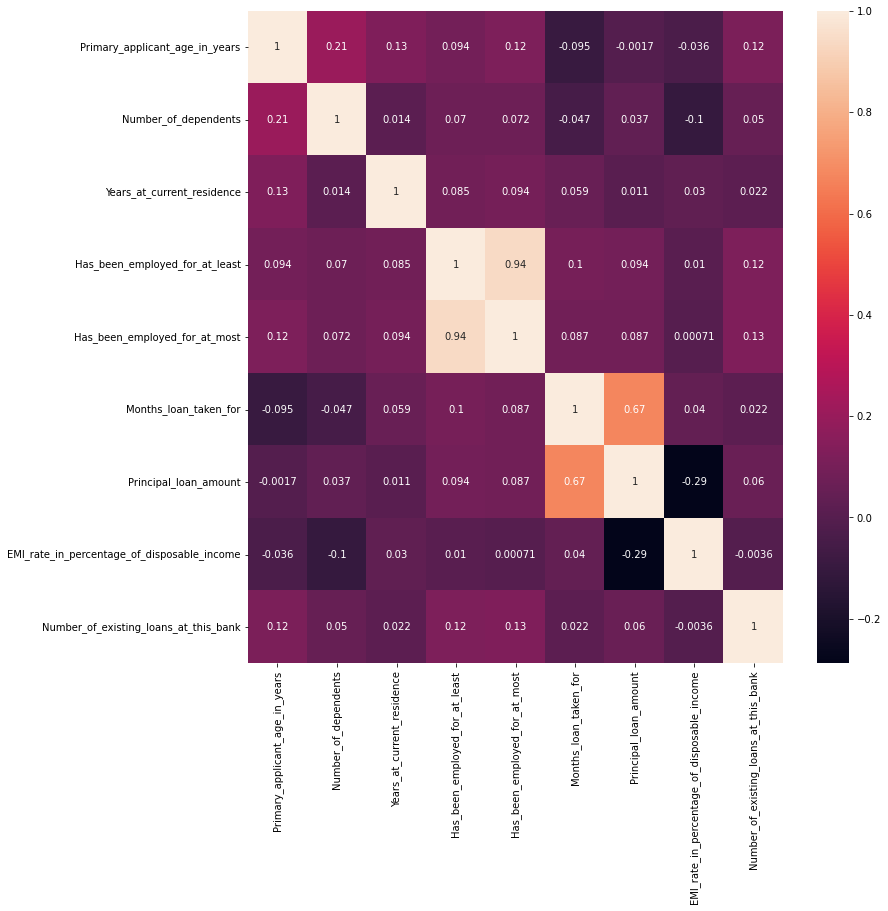

In [306]:
width = 12
height = 12
figure_name = plt.figure(figsize=(width, height))
sns.heatmap(cs.corr(), annot=True)
plt.show()

In [307]:
#cs.drop(['Foreign_worker', 'Has_coapplicant', 'Other_EMI_plans'], axis=1, inplace=True)

In [308]:
cs.nunique()

Primary_applicant_age_in_years                  49
Gender                                           2
Marital_status                                   4
Number_of_dependents                             2
Housing                                          3
Years_at_current_residence                       4
Employment_status                                4
Has_been_employed_for_at_least                   3
Has_been_employed_for_at_most                    3
Foreign_worker                                   2
Savings_account_balance                          4
Months_loan_taken_for                           31
Purpose                                         10
Principal_loan_amount                          548
EMI_rate_in_percentage_of_disposable_income      4
Property                                         4
Has_coapplicant                                  2
Has_guarantor                                    2
Other_EMI_plans                                  3
Number_of_existing_loans_at_thi

In [309]:
cs_cat = cs.select_dtypes(include = 'object').copy()
cs_cont = cs.select_dtypes(include = 'number').copy()

In [310]:
cs[cs.select_dtypes(['object']).columns] = cs.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [311]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in cs_cat.columns[:-1]:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(cs_cat[cs_cat.columns[-1]], cs_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,Loan_history,0.000002
1,Property,0.000034
2,Housing,0.000836
3,Savings_account_balance,0.023928
4,Other_EMI_plans,0.025635
5,Foreign_worker,0.027459
6,Has_coapplicant,0.029643
7,Purpose,0.046188
8,Has_guarantor,0.052169
9,Gender,0.240497


In [312]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
cs_cont.fillna(cs_cont.mean(), inplace = True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(cs_cont, cs_cat['high_risk_applicant'])
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': cs_cont.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,Months_loan_taken_for,55.623447,0.000000
1,Principal_loan_amount,22.181946,0.000003
2,Has_been_employed_for_at_most,12.937325,0.000350
3,Has_been_employed_for_at_least,9.327996,0.002361
4,Primary_applicant_age_in_years,7.717196,0.005648
5,EMI_rate_in_percentage_of_disposable_income,5.664190,0.017639
6,Years_at_current_residence,3.132445,0.077278
7,Number_of_dependents,0.775231,0.378971
8,Number_of_existing_loans_at_this_bank,0.463592,0.496224


In [313]:
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':', drop_first=True))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df.drop(columns_list, axis=1), df_dummies], axis = 1)
    return df

In [314]:
top_num_features = ANOVA_F_table.iloc[:7,0].to_list() #8 best features
top_num_features += chi2_result.iloc[:9,0].to_list() #10 best features
csd = cs[top_num_features]

In [315]:
csd = dummy_creation(csd, [i for i in cs_cat.columns if i in csd.columns and cs[i].nunique()>2])

In [316]:
X = csd #.drop('high_risk_applicant', axis=1)
y = cs['high_risk_applicant'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [317]:
log = LogisticRegression() #xgb.XGBClassifier(objective="binary:logistic", random_state=42)
rfecv = RFECV(estimator=log, cv=StratifiedKFold(10, random_state=50, shuffle=True), scoring="precision")
rfecv.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\Anaconda3\lib\site-packages

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-pa

RFECV(cv=StratifiedKFold(n_splits=10, random_state=50, shuffle=True),
      estimator=LogisticRegression(), scoring='precision')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning:

The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.



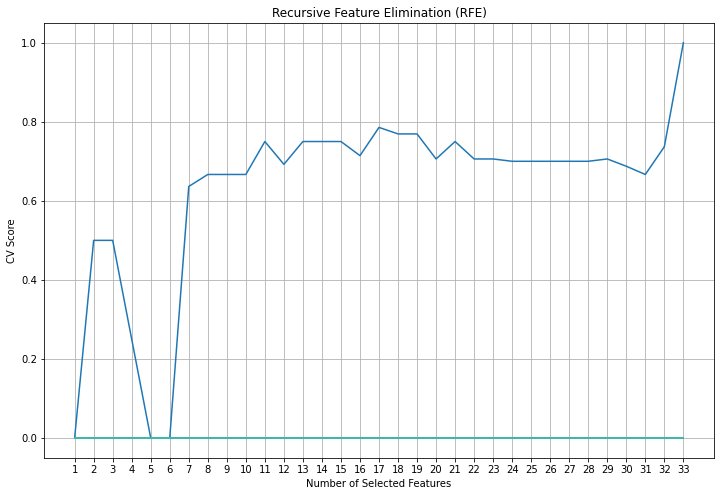

The optimal number of features: 33


In [318]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.grid()
plt.xticks(range(1, X.shape[1]+1))
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()

print("The optimal number of features: {}".format(rfecv.n_features_))

In [319]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

yhat = model.predict(X_test)

report = classification_report(y_test, yhat)
print('classification_report:')
print(report)

classification_report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        72
           1       0.00      0.00      0.00        44

    accuracy                           0.62       116
   macro avg       0.31      0.50      0.38       116
weighted avg       0.39      0.62      0.48       116



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [323]:
rfc = RandomForestClassifier(random_state=50)

forest_params = [{'max_depth': list(range(12, 19)), 'max_features': list(range(23,33))}]

clf = GridSearchCV(rfc, forest_params, cv = 10, scoring='precision')

clf.fit(X_train, y_train)

print(clf.best_params_)

print(clf.best_score_*100)

{'max_depth': 12, 'max_features': 26}
63.25649350649351


In [324]:
rfc = RandomForestClassifier(max_depth = 12, max_features = 26, random_state=50)
rfc.fit(X_train, y_train)
yhat = rfc.predict(X_test)

report = classification_report(y_test, yhat)
print('classification_report:')
print(report)

classification_report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79        72
           1       0.68      0.48      0.56        44

    accuracy                           0.72       116
   macro avg       0.70      0.67      0.67       116
weighted avg       0.71      0.72      0.70       116



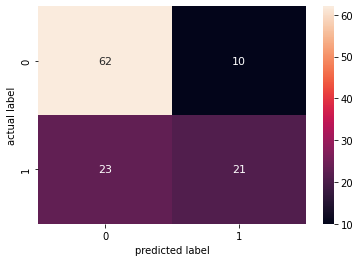

In [325]:
ax = sns.heatmap(confusion_matrix(y_test, yhat), annot=True, annot_kws={"size": 11})
ax.set(xlabel='predicted label', ylabel='actual label')
plt.show()